# Обучаем и обслуживаем модель TensorFlow с помощью TensorFlow Serving




In [1]:
# TensorFlow и tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, Dense
import tempfile
import matplotlib.pyplot as plt
import os
# будем отслеживать все ошибки
import subprocess

import json
import requests
import random
import numpy as np

# Посмотрим на текущую версиб ТФ
print(tf.__version__)

2.3.0


## Загрузка и подготовка данных

In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()
assert train_images.shape == (50000, 32, 32, 3)
assert test_images.shape == (10000, 32, 32, 3)
assert train_labels.shape == (50000, 1)
assert test_labels.shape == (10000, 1)

In [3]:
train_images[0].max()

255

In [4]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [5]:
class_names = ['airplane', 	'automobile', 	'bird', 	'cat', 	'deer', 	'dog', 	'frog', 	'horse', 	'ship', 	'truck']

### Архитектура

In [7]:
# define cnn model  https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [6]:
test_images.shape

(10000, 32, 32, 3)

In [8]:
model = define_model()

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

## Обучение модели

In [11]:
history = model.fit(train_images, train_labels, epochs=15, batch_size=64, validation_data=(test_images, test_labels))
# evaluate model (train_images, train_labels), (test_images, test_labels)

Epoch 1/15
782/782 [==============================] - 206s 263ms/step - loss: 1.6545 - accuracy: 0.4330 - val_loss: 1.2606 - val_accuracy: 0.5480
Epoch 2/15
782/782 [==============================] - 214s 274ms/step - loss: 1.1008 - accuracy: 0.6085 - val_loss: 0.9765 - val_accuracy: 0.6631
Epoch 3/15
782/782 [==============================] - 225s 287ms/step - loss: 0.9145 - accuracy: 0.6792 - val_loss: 0.8039 - val_accuracy: 0.7230
Epoch 4/15
782/782 [==============================] - 229s 292ms/step - loss: 0.8088 - accuracy: 0.7169 - val_loss: 0.8769 - val_accuracy: 0.6928
Epoch 5/15
782/782 [==============================] - 212s 272ms/step - loss: 0.7303 - accuracy: 0.7473 - val_loss: 0.7679 - val_accuracy: 0.7341
Epoch 6/15
782/782 [==============================] - 216s 276ms/step - loss: 0.6714 - accuracy: 0.7686 - val_loss: 0.6040 - val_accuracy: 0.7910
Epoch 7/15
782/782 [==============================] - 212s 271ms/step - loss: 0.6216 - accuracy: 0.7847 - val_loss: 0.5925 -

## Сохраняем модель




Для того, чтобы загрузить модель в TF Serving необходимо сохранит в формате [SavedModel](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/saved_model). Это создаст protobuf файл в папке с четко-прописанной иерархией и присвоит номер версии. Каждая версия экспортируется в разные подпапки по указанному пути.

In [12]:
MODEL_DIR = 'E:/Vadim/N_U/nu29_TFServ/cifar_model'# создание временной директории для хранения модели
version = 1  # номер нашей версии
export_path = os.path.join(MODEL_DIR, str(version)) 
print('Путь для экспорта = {}\n'.format(export_path))

Путь для экспорта = E:/Vadim/N_U/nu29_TFServ/cifar_model\1



In [6]:
if os.path.isdir(export_path):
  print('\nМодель уже сохранена\n')
  !rm -r {export_path}


Модель уже сохранена



"rm" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [13]:
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nСохраненная модель:')
!ls -l {export_path}

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: E:/Vadim/N_U/nu29_TFServ/cifar_model\1\assets

Сохраненная модель:


"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


## Вывод сигнатуры сохраненной модели


Используем утилиту терминала `saved_model_cli` для того, чтобы взглянуть на [MetaGraphDefs](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/MetaGraphDef) (модели) и [SignatureDefs](../signature_defs) (методы, которые вы можете вызвать)  вашей сохраненной модели.
 Еще больше о SavedModel CLI [тут](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/saved_model.md#cli-to-inspect-and-execute-savedmodel).

In [14]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['conv2d_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 32, 32, 3)
        name: serving_default_conv2d_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Defined Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          conv2d_i

## Функция для отрисовки иллюстраций

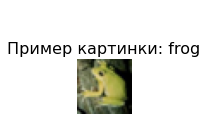

In [15]:
# Функция для просмотра картинки из сета
def show(idx, title):
  plt.figure(figsize=(1, 1))
  plt.imshow(test_images[idx]) #.reshape(28,28), cmap='gray')
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

rando = random.randint(0,len(test_images)-1) # номер случайной картинки
show(rando, 'Пример картинки: {}'.format(class_names[test_labels[rando][0]]))

## Создаем запрос к модели в TensorFlow Serving



### Запустим контейнер с моделью

In [16]:
# проверка состояния docker
!docker container ls

CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES


In [17]:
# sic!
!docker run -d -p 8501:8501 --mount type=bind,source=E:/Vadim/N_U/nu29_TFServ/cifar_model,target=/models/cifar_model \
        -e MODEL_NAME=cifar_model -t tensorflow/serving 

b26dabe3bb833fd139580ed3b287069c09391182cb2b0adff11b8085d9d260b8


In [15]:
!docker container ls
#контейнер запущен:

CONTAINER ID   IMAGE                COMMAND                  CREATED          STATUS          PORTS                              NAMES
2322531af2ef   tensorflow/serving   "/usr/bin/tf_servingвЂ¦"   36 seconds ago   Up 34 seconds   8500/tcp, 0.0.0.0:8501->8501/tcp   beautiful_poitras


### Подготовим данные для REST запроса в формате json

In [28]:
data = json.dumps({"signature_name": "serving_default", "instances": test_images[10:13].tolist()})
#print(data)

### REST запрос на предсказание по 3-м элементам из тестовой выборки

#### Обновленная версия servable/обслуживаемой модели

Пошлем запрос с помощью POST на конечную точку нашего REST сервера и передадим ему 3 образца. Также запросим у сервера последнюю версю обслуживаемой модели, не указывая  конкретно ее версию. 

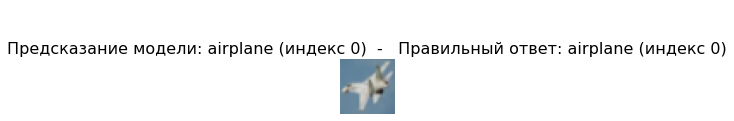

In [24]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/cifar_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

# проверка 1-го предсказанного элемента
show(10, 'Предсказание модели: {} (индекс {})  -   Правильный ответ: {} (индекс {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[10:13][0][0]], test_labels[10:13][0][0]))

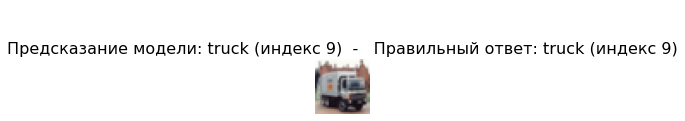

In [26]:
# проверка 2-го предсказанного элемента
show(11, 'Предсказание модели: {} (индекс {})  -   Правильный ответ: {} (индекс {})'.format(
  class_names[np.argmax(predictions[1])], np.argmax(predictions[1]), class_names[test_labels[10:13][1][0]], test_labels[10:13][1][0]))

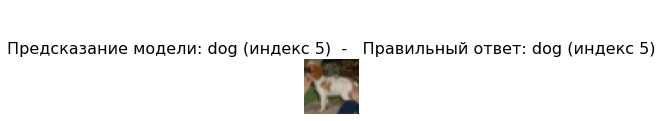

In [27]:
# проверка 3-го предсказанного элемента
show(12, 'Предсказание модели: {} (индекс {})  -   Правильный ответ: {} (индекс {})'.format(
  class_names[np.argmax(predictions[2])], np.argmax(predictions[2]), class_names[test_labels[10:13][2][0]], test_labels[10:13][2][0]))

# numba jit

In [30]:
# Импорт необходимых библиотек
from numba import jit # декоратор numba, который будет оптимизировать наш код
import numpy as np

### без numba

In [31]:
# Создаем случайные наборы чисел
arr = np.arange(1000000).astype(np.float32)

# Функция, которая будет обрабатывать эти числа 
def py_adapt(arr):
  result = np.zeros_like(arr)
  for i in range(len(arr) - 1):
      result[i] = np.sqrt(arr[i] * arr[i + 1])
  return result

In [32]:
# используем чистый python
%timeit py_adapt(arr)

1.65 s ± 188 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### с numba и компиляция

In [38]:
# Используем Numba декоратор с включенным компилятором
@jit(nopython=True)
def nb_adapt(arr):
  result = np.zeros_like(arr)
  for i in range(len(arr) - 1):
      result[i] = np.sqrt(arr[i] * arr[i + 1])  
  return result  

In [39]:
#Numba + Nopython режим

%timeit nb_adapt(arr)

# Magic команды тут https://jakevdp.github.io/PythonDataScienceHandbook/01.03-magic-commands.html

1.49 ms ± 18.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### с numba в объектном режиме 

In [43]:
# Используем Numba декоратор в объектном режиме (питоновском)
@jit(nopython=False)
def nb_adapt(arr):
  result = np.zeros_like(arr)
  for i in range(len(arr) - 1):
      result[i] = np.sqrt(arr[i] * arr[i + 1])
  return result  

In [44]:
#Numba + режим объекта

%timeit -n 1 nb_adapt(arr)

#https://numba.pydata.org/ - больше о Numba

The slowest run took 75.06 times longer than the fastest. This could mean that an intermediate result is being cached.
17.7 ms ± 39.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%timeit -n 1 nb_adapt(arr)

1.77 ms ± 94.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Вывод: ускорение в $10^3$ раз, в случае объектного режима - перввый запуск несколько дольше